# UAS Sightings Exploratory Data Analysis (EDA) with PySpark
**Author(s):** 
* Brett Allen
* Dev Parikh
* Lokesh Reddy Venna

**Environment:**
```
   SageMaker Image: SparkAnalytics 3.0
  SageMaker Kernel: Glue PySpark
SageMaker Instance: ml.t3.medium (2 vCPU + 4 GiB @ $0.0416/hr) - EBS storage only (for HDFS)
```

**NOTE:** Must have the specified `%profile` available on system. Install AWS CLI via `pip install awscli` and run `aws configure` to initialize CLI environment. Must have generated keys in IAM first.

**NOTE:** Additional jars are required for `apache-sedona`. Refer to https://sedona.apache.org/1.3.1-incubating/setup/install-python/

**NOTE:** Download the following jars and upload to s3 for reference via `%extra_jars` magic (for Glue 3.0 support):
* `geotools-wrapper-1.1.0-25.2.jar`: https://mvnrepository.com/artifact/org.datasyslab/geotools-wrapper/1.1.0-25.2
* `gt-epsg-hsql-24.0.jar`: https://mvnrepository.com/artifact/org.geotools/gt-epsg-hsql/24.0
* `gt-main-24.0.jar`: https://mvnrepository.com/artifact/org.geotools/gt-main/24.0
* `gt-referencing-24.0.jar`: https://mvnrepository.com/artifact/org.geotools/gt-referencing/24.0
* `jts-core-1.18.2.jar`: https://mvnrepository.com/artifact/org.locationtech.jts/jts-core/1.18.2
* `jts-io-common-1.18.2.jar`: https://mvnrepository.com/artifact/org.locationtech.jts.io/jts-io-common/1.18.2
* `sedona-core-3.0_2.12-1.1.0-incubating.jar`: https://mvnrepository.com/artifact/org.apache.sedona/sedona-core-3.0_2.12/1.1.0-incubating
* `sedona-python-adapter-3.0_2.12-1.1.0-incubating.jar`: https://mvnrepository.com/artifact/org.apache.sedona/sedona-python-adapter-3.0_2.12/1.1.0-incubating
* `sedona-sql-3.0_2.12-1.1.0-incubating.jar`: https://mvnrepository.com/artifact/org.apache.sedona/sedona-sql-3.0_2.12/1.1.0-incubating
* `sedona-viz-3.0_2.12-1.1.0-incubating.jar`: https://mvnrepository.com/artifact/org.apache.sedona/sedona-viz-3.0_2.12/1.1.0-incubating


In [9]:
%iam_role arn:aws:iam::867344433302:role/endurasoft-GlueJobServiceRole
%profile default
%etl
%number_of_workers 2
%worker_type G.2X
%glue_version 3.0
%additional_python_modules "plotly-express,datashader,apache-sedona,geopandas,shapely,geojson,dask[dataframe],folium"
%extra_jars "s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/geotools-wrapper-1.1.0-25.2.jar,s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/gt-epsg-hsql-24.0.jar,s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/gt-main-24.0.jar,s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/gt-referencing-24.0.jar,s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/jts-core-1.18.2.jar,s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/jts-io-common-1.18.2.jar,s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/sedona-core-3.0_2.12-1.1.0-incubating.jar,s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/sedona-python-adapter-3.0_2.12-1.1.0-incubating.jar,s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/sedona-sql-3.0_2.12-1.1.0-incubating.jar,s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/sedona-viz-3.0_2.12-1.1.0-incubating.jar"

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.7 
Current iam_role is arn:aws:iam::867344433302:role/service-role/SageMaker-ExecutionRole-20241012T165481
iam_role has been set to arn:aws:iam::867344433302:role/endurasoft-GlueJobServiceRole.
Previous profile: None
Setting new profile to: default
Previous session type: etl
Setting new session type to ETL
Previous number of workers: None
Setting new number of workers to: 2
Previous worker type: None
Setting new worker type to: G.2X
Setting Glue version to: 3.0
Additional python modules to be included:
plotly-express
datashader
apache-sedona
geopandas
shapely
geojson
dask[dataframe]
folium
Extra jars to be included:
s3://endurasoft-dev-risk-fra

## Imports

In [111]:
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from awsglue.context import GlueContext
from awsglue.job import Job
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.window import Window
from pyspark import StorageLevel
from pyspark.context import SparkContext
from pyspark.conf import SparkConf
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StringIndexer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation
from pyspark.mllib.linalg.distributed import RowMatrix
from sedona.register import SedonaRegistrator
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.formatMapper import GeoJsonReader
from sedona.core.enums import FileDataSplitter, IndexType, GridType
from sedona.core import SpatialRDD
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.utils.adapter import Adapter
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import shape, Point, Polygon
import re
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import plotly.express as px
from colorcet import fire
import datashader.transfer_functions as tf
import datashader as ds
import boto3
import io
import json
import geojson
import os
import zipfile
from zipfile import ZipFile
import subprocess
import numpy as np
from scipy.ndimage import gaussian_filter

In [11]:
%status

Session ID: b4961618-1c6e-4d3b-a9bd-e039331319b7
Status: READY
Role: arn:aws:iam::867344433302:role/endurasoft-GlueJobServiceRole
CreatedOn: 2024-12-05 12:46:55.976000+00:00
GlueVersion: 3.0
Session Type: glueetl
Idle Timeout: 2880
Timeout: 2880
Tags: {'owner': 'AIDA4T4OBYCLOCNMZTZU3', 'sagemaker:user-profile-arn': 'arn:aws:sagemaker:us-east-1:867344433302:user-profile/d-eikyi6u8iy8g/ballen', 'sagemaker:domain-arn': 'arn:aws:sagemaker:us-east-1:867344433302:domain/d-eikyi6u8iy8g', 'sagemaker:space-arn': 'arn:aws:sagemaker:us-east-1:867344433302:space/d-eikyi6u8iy8g/Bretts-Private-JupyterLab-Space'}
Worker Type: G.2X
Number of Workers: 2
Region: us-east-1
Applying the following default arguments:
--glue_kernel_version 1.0.7
--enable-glue-datacatalog true
--extra-jars s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/geotools-wrapper-1.1.0-25.2.jar,s3://endurasoft-dev-risk-framework/config/jars/apache_sedona_glue_v3/gt-epsg-hsql-24.0.jar,s3://endurasoft-dev-risk-framew

## Configurations
For reference/guidance on using sedona for geospatial analysis, see https://anant-sharma.medium.com/apache-sedona-geospark-using-pyspark-e60485318fbe

In [ ]:
# Initialize spark context and glue context to create glue job for analysis
conf = SparkConf()
conf.set("spark.serializer", KryoSerializer.getName)\
    .set("spark.kryo.registrator", SedonaKryoRegistrator.getName)
sc = SparkContext.getOrCreate(conf=conf)
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

In [ ]:
# Register spark with sedona
SedonaRegistrator.registerAll(spark)

True


In [ ]:
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")
spark.conf.set("spark.sql.parquet.enableVectorizedReader", "false")
spark.conf.set("spark.sql.broadcastTimeout", "1200") # 1200 seconds = 20 minutes

In [ ]:
s3_client = boto3.client('s3')

In [ ]:
sns.set_style('darkgrid')

## Load the Data

### Track Points
Loading OpenSky Network data.
* Flight Recorder Data: `s3://endurasoft-dev-risk-framework/opensky-network/track-points/`

In [7]:
# NOTE: Loading 2024-08-01 through 2024-09-30 for proof of concept purposes.
# track_points_df = spark.read.parquet("s3://endurasoft-dev-risk-framework/opensky-network/track-points/year=*/month=*/day=*/hour=*/*.parquet")            # Full dataset
# track_points_df = spark.read.parquet("s3://endurasoft-dev-risk-framework/opensky-network/track-points/year=2024/month=*/day=*/hour=*/*.parquet")         # 1 year from full dataset
# track_points_df = spark.read.parquet("s3://endurasoft-dev-risk-framework/opensky-network/track-points/year=2024/month=[8-9]/day=*/hour=*/*.parquet")     # 2 months from full dataset
# track_points_df = spark.read.parquet("s3://endurasoft-dev-risk-framework/datasets/track-points/year=*/month=*/day=*/hour=*/*.parquet")                   # Sample dataset (sync with uas sightings)
# track_points_df = spark.read.parquet('s3://endurasoft-dev-risk-framework/datasets/sampled-track-points/year=2024/month=[8-9]/day=*/hour=*/*.parquet')    # 2 months from sample dataset
track_points_df = spark.read.parquet("s3://endurasoft-dev-risk-framework/datasets/grid-ceiling-track-points/year=2024/month=[7-9]/day=*/hour=*/*.parquet") # 3 months from grid ceiling track points
track_points_df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- icao24: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- velocity: double (nullable = true)
 |-- heading: double (nullable = true)
 |-- vertrate: double (nullable = true)
 |-- callsign: string (nullable = true)
 |-- onground: integer (nullable = true)
 |-- alert: integer (nullable = true)
 |-- spi: integer (nullable = true)
 |-- baroaltitude: double (nullable = true)
 |-- geoaltitude: double (nullable = true)
 |-- lastposupdate: double (nullable = true)
 |-- lastcontact: double (nullable = true)
 |-- serials: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- day_of_week: string (nullable = true)
 |-- daynum_of_week: integer (nullable = true)
 |-- month_name: string (nullable = true)


In [8]:
# NOTE: Full dataset is too large to persist; must target smaller subset to persist
track_points_df.persist()

DataFrame[time: timestamp, icao24: string, lat: double, lon: double, velocity: double, heading: double, vertrate: double, callsign: string, onground: int, alert: int, spi: int, baroaltitude: double, geoaltitude: double, lastposupdate: double, lastcontact: double, serials: array<bigint>, day_of_week: string, daynum_of_week: int, month_name: string]


In [9]:
track_points_count = track_points_df.count()

In [10]:
print(f'Total track points: {track_points_count:,}')

Total track points: 27,362,475


**Observation:** After syncing with UAS sightings data (later step), sampling the track points to reduce density (later step), and loading only the last two months, we have sufficiently reduced the dataset such that the memory footprint is small enough to persist in memory and disk.

### UAS Sightings
Loading UAS sightings reports converted to tabular format.
* `s3://endurasoft-dev-risk-framework/datasets/uas_sightings_reports/zero_shot/uas_sightings.parquet`

In [ ]:
uas_sightings_df = spark.read.parquet("s3://endurasoft-dev-risk-framework/datasets/uas_sightings_reports/zero_shot/uas_sightings.parquet")
uas_sightings_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- report_date: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- report_narrative: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- altitude: long (nullable = true)
 |-- uncertainty: string (nullable = true)


In [ ]:
uas_sightings_df.persist()

DataFrame[id: bigint, report_date: string, city: string, state: string, report_narrative: string, timestamp: string, latitude: double, longitude: double, altitude: bigint, uncertainty: string]


### UAS Facility Maps (UASFM) Grids
Loading UAS Facility Map (UASFM) grids data. This data should be fused with UAS sightings data and track points data for risk analysis.
* `s3://endurasoft-dev-risk-framework/datasets/uasfm_grids/FAA_UAS_FacilityMap_Data.parquet`
* `s3://endurasoft-dev-risk-framework/datasets/uasfm_grids/FAA_UAS_FacilityMap_Data/FAA_UAS_FacilityMap_Data.shp`

In [13]:
# uasfm_df = spark.read.parquet("s3://endurasoft-dev-risk-framework/datasets/uasfm_grids/FAA_UAS_FacilityMap_Data.parquet")
# uasfm_df = spark.read.format("shapefile").load('s3://endurasoft-dev-risk-framework/datasets/uasfm_grids/FAA_UAS_FacilityMap_Data/FAA_UAS_FacilityMap_Data.shp')
# uasfm_rdd = ShapefileReader.readToGeometryRDD(sc, "s3://endurasoft-dev-risk-framework/datasets/uasfm_grids/FAA_UAS_FacilityMap_Data/")
# uasfm_rdd = GeoJsonReader.readToGeometryRDD(sc, "s3://endurasoft-dev-risk-framework/datasets/uasfm_grids/FAA_UAS_FacilityMap_Data.geojson")
# uasfm_df = spark.read.json("s3://endurasoft-dev-risk-framework/datasets/uasfm_grids/FAA_UAS_FacilityMap_Data.geojson")
uasfm_geo_df = gpd.read_file('s3://endurasoft-dev-risk-framework/datasets/uasfm_grids/FAA_UAS_FacilityMap_Data.geojson')

In [14]:
# Convert geometry to wkt for pyspark support
uasfm_geo_df['wkt'] = uasfm_geo_df['geometry'].apply(lambda geom: geom.wkt)

In [15]:
# Get rid of geometry column now that we have a wkt column that represents it
uasfm_geo_df.drop('geometry', axis=1, inplace=True)

In [16]:
uasfm_geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 376569 entries, 0 to 376568
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   OBJECTID         376569 non-null  int64  
 1   CEILING          376569 non-null  int64  
 2   UNIT             376569 non-null  object 
 3   MAP_EFF          376569 non-null  object 
 4   LAST_EDIT        376569 non-null  object 
 5   LATITUDE         376569 non-null  float64
 6   LONGITUDE        376569 non-null  float64
 7   GLOBALID         376569 non-null  object 
 8   ARPT_COUNT       376569 non-null  int64  
 9   APT1_FAAID       376569 non-null  object 
 10  APT1_ICAO        376569 non-null  object 
 11  APT1_NAME        376569 non-null  object 
 12  APT1_LAANC       376569 non-null  int64  
 13  APT2_FAAID       376569 non-null  object 
 14  APT2_ICAO        376569 non-null  object 
 15  APT2_NAME        376569 non-null  object 
 16  APT2_LAANC       3636 non-null

In [17]:
uasfm_geo_df.head(1).T

                                                                 0
OBJECTID                                                         1
CEILING                                                        400
UNIT                                                          Feet
MAP_EFF                                                 11/28/2024
LAST_EDIT                                                9/23/2020
LATITUDE                                                 41.679174
LONGITUDE                                               -70.320839
GLOBALID                      c7df8c7b-3ede-4dc8-ae2c-68b12ce85a52
ARPT_COUNT                                                       1
APT1_FAAID                                                     HYA
APT1_ICAO                                                     KHYA
APT1_NAME                                         Cape Cod Gateway
APT1_LAANC                                                       1
APT2_FAAID                                                    

In [18]:
pd_to_spark_type_map = {
    'int64': T.IntegerType(),
    'object': T.StringType(),
    'float64': T.FloatType(),
}

In [19]:
uasfm_schema_types = []
for col, dtype in zip(uasfm_geo_df.columns, uasfm_geo_df.dtypes):
    # print(col, dtype, pd_to_spark_type_map.get(str(dtype)))
    spark_dtype = pd_to_spark_type_map.get(str(dtype))
    uasfm_schema_types.append(T.StructField(col, spark_dtype, True))

In [20]:
# Create schema for pyspark conversion
uasfm_schema = T.StructType(uasfm_schema_types)

In [21]:
# Convert geopandas to pyspark
uasfm_df = spark.createDataFrame(uasfm_geo_df, schema=uasfm_schema)

In [22]:
uasfm_df.printSchema()

root
 |-- OBJECTID: integer (nullable = true)
 |-- CEILING: integer (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- MAP_EFF: string (nullable = true)
 |-- LAST_EDIT: string (nullable = true)
 |-- LATITUDE: float (nullable = true)
 |-- LONGITUDE: float (nullable = true)
 |-- GLOBALID: string (nullable = true)
 |-- ARPT_COUNT: integer (nullable = true)
 |-- APT1_FAAID: string (nullable = true)
 |-- APT1_ICAO: string (nullable = true)
 |-- APT1_NAME: string (nullable = true)
 |-- APT1_LAANC: integer (nullable = true)
 |-- APT2_FAAID: string (nullable = true)
 |-- APT2_ICAO: string (nullable = true)
 |-- APT2_NAME: string (nullable = true)
 |-- APT2_LAANC: float (nullable = true)
 |-- APT3_FAAID: string (nullable = true)
 |-- APT3_ICAO: string (nullable = true)
 |-- APT3_NAME: string (nullable = true)
 |-- APT3_LAANC: float (nullable = true)
 |-- APT4_FAAID: string (nullable = true)
 |-- APT4_ICAO: string (nullable = true)
 |-- APT4_NAME: string (nullable = true)
 |-- APT4_LAANC

In [23]:
# Convert WKT back to geometry using sedona
uasfm_df = uasfm_df.withColumn("geometry", F.expr("ST_GeomFromWKT(wkt)"))

In [24]:
uasfm_df.printSchema()

root
 |-- OBJECTID: integer (nullable = true)
 |-- CEILING: integer (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- MAP_EFF: string (nullable = true)
 |-- LAST_EDIT: string (nullable = true)
 |-- LATITUDE: float (nullable = true)
 |-- LONGITUDE: float (nullable = true)
 |-- GLOBALID: string (nullable = true)
 |-- ARPT_COUNT: integer (nullable = true)
 |-- APT1_FAAID: string (nullable = true)
 |-- APT1_ICAO: string (nullable = true)
 |-- APT1_NAME: string (nullable = true)
 |-- APT1_LAANC: integer (nullable = true)
 |-- APT2_FAAID: string (nullable = true)
 |-- APT2_ICAO: string (nullable = true)
 |-- APT2_NAME: string (nullable = true)
 |-- APT2_LAANC: float (nullable = true)
 |-- APT3_FAAID: string (nullable = true)
 |-- APT3_ICAO: string (nullable = true)
 |-- APT3_NAME: string (nullable = true)
 |-- APT3_LAANC: float (nullable = true)
 |-- APT4_FAAID: string (nullable = true)
 |-- APT4_ICAO: string (nullable = true)
 |-- APT4_NAME: string (nullable = true)
 |-- APT4_LAANC

In [25]:
uasfm_df.persist()

DataFrame[OBJECTID: int, CEILING: int, UNIT: string, MAP_EFF: string, LAST_EDIT: string, LATITUDE: float, LONGITUDE: float, GLOBALID: string, ARPT_COUNT: int, APT1_FAAID: string, APT1_ICAO: string, APT1_NAME: string, APT1_LAANC: int, APT2_FAAID: string, APT2_ICAO: string, APT2_NAME: string, APT2_LAANC: float, APT3_FAAID: string, APT3_ICAO: string, APT3_NAME: string, APT3_LAANC: float, APT4_FAAID: string, APT4_ICAO: string, APT4_NAME: string, APT4_LAANC: string, APT5_FAAID: string, APT5_ICAO: string, APT5_NAME: string, APT5_LAANC: string, AIRS_COUNT: int, AIRSPACE_1: string, AIRSPACE_2: string, AIRSPACE_3: string, AIRSPACE_4: string, AIRSPACE_5: string, REGION: string, APT1_Enabled: string, APT2_Enabled: string, APT3_Enabled: string, APT4_Enabled: string, APT5_Enabled: string, Shape__Length: string, Shape__Area: string, Shape__Area_2: float, Shape__Length_2: float, wkt: string, geometry: udt]


In [26]:
# Show results
uasfm_df.show(n=1, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 OBJECTID        | 1                                                                                                                                                                                                          
 CEILING         | 400                                                                                                                                                                                                        
 UNIT            | Feet                                                                                                                                                                                                       
 MAP_EFF         | 11/28/2024                                                                               

In [27]:
uasfm_grids_count = uasfm_df.count()

In [28]:
print(f'UASFM grids count: {uasfm_grids_count:,}')

UASFM grids count: 376,569


## Exploratory Data Analysis (EDA)

In [29]:
def clean_column_names(df: DataFrame) -> DataFrame:
    """
    Rename columns by lowercasing them and replacing spaces, dots, and forward slashes with underscores.

    Args:
        df (DataFrame): Spark dataframe to clean column names.

    Returns:
        DataFrame: New Spark dataframe with cleaned column names.
    """
    # Convert column names to lowercase and replace spaces, dots, and forward slashes with underscores
    return df.toDF(*[ re.sub(r'[ \.\/]+', '_', c.lower()) for c in df.columns ])

In [30]:
# Create function to show more information on missing values
def get_missing_values(df: DataFrame) -> DataFrame:
    """
    Create a dataframe to represent the missing values in the original dataframe.

    Args:
        df (DataFrame): Original dataframe to identify missing values.

    Returns:
        DataFrame: New dataframe representing a report of missing values in original dataframe.
    """
    total_records = df.count()
    
    # For each column, calculate the total missing, available, ratio, and percentage of missing values
    missing_stats = []
    
    for column in df.columns:
        total_missing = df.select(F.count(F.when(F.col(column).isNull(), column)).alias("total_missing")).collect()[0][0]
        total_available = total_records - total_missing
        ratio_missing = total_missing / total_records
        percent_missing = round(ratio_missing * 100, 1)
        
        missing_stats.append({
            'column': column,
            'total_missing': total_missing,
            'total_available': total_available,
            'ratio_missing': round(ratio_missing, 4),
            'percent_missing': f'{percent_missing}%'
        })
    
    # Create a DataFrame from the list of dictionaries
    result_df = df.sql_ctx.createDataFrame(missing_stats)
    
    # Ensure correct column order
    return result_df.select(['column', 'total_missing', 'total_available', 'ratio_missing', 'percent_missing'])

In [31]:
def get_unique_values(df: DataFrame) -> DataFrame:
    """
    Get unique values for each column in provided Spark dataframe.

    Args:
        df (DataFrame): Spark dataframe to identify unique values.

    Returns:
        DataFrame: Spark dataframe representing unique values.
    """
    # NOTE: Can use approx_count_distinct (see https://stackoverflow.com/a/53764762)
    return df.agg(*(F.countDistinct(F.col(c)).alias(c) for c in df.columns))

In [32]:
def add_point_wkt(row: Row, lat_col: str, lon_col: str, alt_col: str, point_wkt_col: str='point_wkt') -> Row:
    """
    Create 3D point geometry and capture its WKT string as a new column in provided row.

    Args:
        row (Row): Row containing relevant data to build 3D point.
        lat_col (str): Name of column representing latitude.
        lon_col (str): Name of column representing longitude.
        alt_col (str): Name of column representing altitude.
        point_wkt_col (str, optional): Name of column to be created for point wkt. Defaults to 'point_wkt'.

    Returns:
        Row: New row containing 3D point WKT string.
    """
    dictRow = row.asDict()
    lat = dictRow.get(lat_col)
    lng = dictRow.get(lon_col)
    alt = dictRow.get(alt_col, 0) # Set altitude to 0 if null to prevent errors
    dictRow[point_wkt_col] = Point( lng, lat, alt ).wkt
    newrow = Row(**dictRow)
    return newrow

In [33]:
def generate_histplot(df: DataFrame, feature_col: str, bins: int=20, figsize: tuple=(12, 12), title: str=None):
    """
    Create and display histogram plot using spark dataframe, based on a desired feature column.

    **NOTE:** Must use "%matplot plt" to render plots in glue pyspark kernel. Include this magic directly after calling this function. For example:

    ```python
    generate_histplot(...)
    %matplot plt
    ```

    Args:
        df (DataFrame): Spark dataframe to identify feature and plot histogram for.
        feature_col (str): Desired feature to create histogram for
        bins (int, optional): Number of bins for the histogram. Defaults to 20.
        figsize (tuple, optional): Size of the figure to plot. Defaults to (12, 12).
        title (str, optional): Title of the plot. Defaults to None and uses default title, "Distribution of {feature_col}".
    """
    # Analyze distribution of target feature
    hist = df.select(feature_col).rdd.flatMap(lambda x: x).histogram(bins)

    # Plot the histogram for barometric altitude
    plt.figure(figsize=figsize)
    hist_df = pd.DataFrame(
        list(zip(*hist)),
        columns=['bin', 'frequency']
    )
    hist_df['bin'] = hist_df['bin'].round(2)
    hist_df.set_index('bin').plot(kind='bar')
    plt.xlabel(None)
    plt.xticks(rotation=45, ha='right')
    plt.title(title or f'Distribution of {feature_col}')
    plt.tight_layout()
    plt.show()

### UASFM Grids
Source: https://uas-faa.opendata.arcgis.com/datasets/faa::faa-uas-facilitymap-data/about

In [34]:
uasfm_df = clean_column_names(uasfm_df)

In [35]:
# Convert boolean columns to integer
bool_cols = [col_name for col_name, col_type in uasfm_df.dtypes if col_type == "boolean"]

# Convert boolean columns to integers
for col_name in bool_cols:
    uasfm_df = uasfm_df.withColumn(col_name, F.col(col_name).cast(T.IntegerType()))

In [36]:
uasfm_df.show(n=1, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 objectid        | 1                                                                                                                                                                                                          
 ceiling         | 400                                                                                                                                                                                                        
 unit            | Feet                                                                                                                                                                                                       
 map_eff         | 11/28/2024                                                                               

#### Analyze Ceiling Range

In [37]:
uasfm_df.select('ceiling').describe().show(truncate=False)

+-------+-----------------+
|summary|ceiling          |
+-------+-----------------+
|count  |376569           |
|mean   |246.5857518807974|
|stddev |160.637926423644 |
|min    |0                |
|max    |400              |
+-------+-----------------+


In [38]:
# Get the min and max values of the 'age' column
min_ceiling = uasfm_df.select(F.min("ceiling")).collect()[0][0]
max_ceiling = uasfm_df.select(F.max("ceiling")).collect()[0][0]

In [39]:
print(f'Minimum Ceiling: {min_ceiling:,}')
print(f'Maximum Ceiling: {max_ceiling:,}')

Minimum Ceiling: 0
Maximum Ceiling: 400


### UAS Sightings

In [ ]:
# Clean column names
uas_sightings_df = clean_column_names(uas_sightings_df)

In [ ]:
# Convert boolean columns to integer
bool_cols = [col_name for col_name, col_type in uas_sightings_df.dtypes if col_type == "boolean"]

# Convert boolean columns to integers
for col_name in bool_cols:
    uas_sightings_df = uas_sightings_df.withColumn(col_name, F.col(col_name).cast(T.IntegerType()))

In [ ]:
uas_sightings_df.persist()

DataFrame[id: bigint, report_date: string, city: string, state: string, report_narrative: string, timestamp: string, latitude: double, longitude: double, altitude: bigint, uncertainty: string]


In [ ]:
uas_sightings_df.show(n=1, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id               | 2293                                                                                                                                                                                                                                                                                                                                                                                                                                              
 report_date      | 2023-06-01                                                            

#### Descriptive Statistics

In [ ]:
uas_sightings_df.describe().show(n=len(uas_sightings_df.columns), vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 summary          | count                                                                                                                                                                                                                                                                                                                                                                                                                                            
 id               | 2274                                                                    

#### Date Range and Total Records

In [ ]:
# Analyze date range for dataset
uas_sightings_df = uas_sightings_df.withColumn('report_date', F.to_timestamp('report_date'))

# Get the start and end dates
uas_sightings_start_date = uas_sightings_df.select(F.min("report_date")).collect()[0][0]
uas_sightings_end_date = uas_sightings_df.select(F.max("report_date")).collect()[0][0]

print("Start Date :", uas_sightings_start_date)
print("End Date   :", uas_sightings_end_date)

Start Date : 2023-06-01 00:00:00
End Date   : 2024-09-30 00:00:00


In [ ]:
uas_sightings_date_diff = uas_sightings_end_date - uas_sightings_start_date
print(f'UAS Sightings dataset spans {uas_sightings_date_diff.days} days ({round(uas_sightings_date_diff.days/365, 2)} years)')

UAS Sightings dataset spans 487 days (1.33 years)


In [ ]:
print(f'Total UAS sightings records: {uas_sightings_df.count():,}')

Total UAS sightings records: 2,274


#### Analyze Nulls

In [ ]:
uas_sightings_missing_values_report = get_missing_values(uas_sightings_df)
uas_sightings_missing_values_report.show(n=len(uas_sightings_df.columns), truncate=False)

+----------------+-------------+---------------+-------------+---------------+
|column          |total_missing|total_available|ratio_missing|percent_missing|
+----------------+-------------+---------------+-------------+---------------+
|id              |0            |2274           |0.0          |0.0%           |
|report_date     |0            |2274           |0.0          |0.0%           |
|city            |0            |2274           |0.0          |0.0%           |
|state           |0            |2274           |0.0          |0.0%           |
|report_narrative|0            |2274           |0.0          |0.0%           |
|timestamp       |0            |2274           |0.0          |0.0%           |
|latitude        |0            |2274           |0.0          |0.0%           |
|longitude       |0            |2274           |0.0          |0.0%           |
|altitude        |0            |2274           |0.0          |0.0%           |
|uncertainty     |0            |2274           |0.0 

#### Analyze Uniqueness

In [ ]:
uas_sightings_unique_counts = get_unique_values(uas_sightings_df)
uas_sightings_unique_counts.show(n=len(uas_sightings_df.columns), vertical=True, truncate=False)

-RECORD 0----------------
 id               | 2274 
 report_date      | 467  
 city             | 430  
 state            | 56   
 report_narrative | 2268 
 timestamp        | 729  
 latitude         | 807  
 longitude        | 976  
 altitude         | 168  
 uncertainty      | 2


**Observation:** The majority of the features for UAS sightings are unique with the exception of a few features such as `state` and `uncertainty`. We could categorical encode these features but it is unnecessary for the scope of risk analysis.

#### Analyze Sightings by Altitude Bins

In [ ]:
alt_bins = [0, 150, 200, 250, 500, 750, 1000, 2500, 5000, 10000, float("inf")]
alt_labels = ['<150', '150-200', '200-250', '250-500', '500-750', '750-1000', '1000-2500', '2500-5000', '5000-10000', '>10000']

In [ ]:
# Create the altitude bins for altitude and aircraft_1_altitudeinfeet
uas_sightings_df = uas_sightings_df.withColumn("altitude_bin", 
                   F.when(F.col("altitude") < alt_bins[1], alt_labels[0])
                   .when((F.col("altitude") >= alt_bins[1]) & (F.col("altitude") < alt_bins[2]), alt_labels[1])
                   .when((F.col("altitude") >= alt_bins[2]) & (F.col("altitude") < alt_bins[3]), alt_labels[2])
                   .when((F.col("altitude") >= alt_bins[3]) & (F.col("altitude") < alt_bins[4]), alt_labels[3])
                   .when((F.col("altitude") >= alt_bins[4]) & (F.col("altitude") < alt_bins[5]), alt_labels[4])
                   .when((F.col("altitude") >= alt_bins[5]) & (F.col("altitude") < alt_bins[6]), alt_labels[5])
                   .when((F.col("altitude") >= alt_bins[6]) & (F.col("altitude") < alt_bins[7]), alt_labels[6])
                   .when((F.col("altitude") >= alt_bins[7]) & (F.col("altitude") < alt_bins[8]), alt_labels[7])
                   .when((F.col("altitude") >= alt_bins[8]) & (F.col("altitude") < alt_bins[9]), alt_labels[8])
                   .otherwise(alt_labels[9]))

In [ ]:
# Analyze event score by aircraft_0_altitude_bin
print('='*100)
print(f'UAS Sightings by Altitude Bins')
print('='*100)
uas_sightings_df.groupBy('altitude_bin').agg(
    F.count('*').alias('sightings_count'),
).orderBy(F.col('sightings_count').desc()).show()

UAS Sightings by Altitude Bins
+------------+---------------+
|altitude_bin|sightings_count|
+------------+---------------+
|   1000-2500|            695|
|   2500-5000|            588|
|  5000-10000|            444|
|      >10000|            225|
|     500-750|            135|
|    750-1000|             75|
|     250-500|             64|
|        <150|             25|
|     200-250|             18|
|     150-200|              5|
+------------+---------------+


#### Filter by Altitude to Match Grids Ceiling
Filtering by altitude to match the min/max range of UASFM grid ceilings will ensure only the records of interest get analyzed for geospatial risk analysis.

In [ ]:
uas_sightings_df = uas_sightings_df.filter(uas_sightings_df["altitude"].between(min_ceiling, max_ceiling))

In [ ]:
uas_sightings_df.persist()

DataFrame[id: bigint, report_date: string, city: string, state: string, report_narrative: string, timestamp: string, latitude: double, longitude: double, altitude: bigint, uncertainty: string]


In [ ]:
filtered_uas_sightings_count = uas_sightings_df.count()

In [ ]:
print(f'Filtered UAS sightings count: {filtered_uas_sightings_count:,}')

Filtered UAS sightings count: 111


#### Add Point Geometry for UAS Sightings

In [ ]:
# Create schema for RDD
uas_sightings_schema = T.StructType(list(uas_sightings_df.schema) + [T.StructField("point_wkt", T.StringType(), True)])

# Capture RDD
uas_sightings_rdd = uas_sightings_df.rdd

# Add point geometry
uas_sightings_rdd = uas_sightings_rdd.map(lambda row: add_point_wkt(row, lat_col='latitude', lon_col='longitude', alt_col='altitude', point_wkt_col='point_wkt'))

# Transform RDD with point geometry back to spark dataframe
uas_sightings_df = spark.createDataFrame(uas_sightings_rdd, schema=uas_sightings_schema).persist()

In [ ]:
# Convert point WKT to geometry using sedona
uas_sightings_df = uas_sightings_df.withColumn("point_geometry", F.expr("ST_GeomFromWKT(point_wkt)"))

In [ ]:
uas_sightings_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- report_date: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- report_narrative: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- altitude: long (nullable = true)
 |-- uncertainty: string (nullable = true)
 |-- point_wkt: string (nullable = true)
 |-- point_geometry: geometry (nullable = false)


In [ ]:
uas_sightings_df.show(n=1, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id               | 2308                                                                                                                                                                                                                                                                                                                                                                                                                                                     
 report_date      | 2023-06-03                                              

**Observation:** Unfortunately, Apache Sedona does not support 3D point geometry and has automatically converted the 3D point WKT to a 2D point geomtry. Therefore, we will need to consider altitude as a separate clause during geospatial joins.

### Track Points

In [52]:
# Clean column names
track_points_df = clean_column_names(track_points_df)

In [53]:
# Convert boolean columns to integer
bool_cols = [col_name for col_name, col_type in track_points_df.dtypes if col_type == "boolean"]

# Convert boolean columns to integers
for col_name in bool_cols:
    track_points_df = track_points_df.withColumn(col_name, F.col(col_name).cast(T.IntegerType()))

In [54]:
# NOTE: Full dataset is too large to persist; must target smaller subset to persist
track_points_df.persist()

DataFrame[time: timestamp, icao24: string, lat: double, lon: double, velocity: double, heading: double, vertrate: double, callsign: string, onground: int, alert: int, spi: int, baroaltitude: double, geoaltitude: double, lastposupdate: double, lastcontact: double, serials: array<bigint>, day_of_week: string, daynum_of_week: int, month_name: string]


In [55]:
track_points_df.show(n=1, vertical=True, truncate=False)

-RECORD 0-----------------------------
 time           | 2024-07-19 11:00:02 
 icao24         | a025bc              
 lat            | 29.309646606445312  
 lon            | -81.1421673114483   
 velocity       | 53.800611565858915  
 heading        | 6.037682521422889   
 vertrate       | 4.22656             
 callsign       | JED122              
 onground       | 0                   
 alert          | 0                   
 spi            | 0                   
 baroaltitude   | 281.94              
 geoaltitude    | 289.56              
 lastposupdate  | 1.721386801701E9    
 lastcontact    | 1.721386801701E9    
 serials        | [-1408235449]       
 day_of_week    | Friday              
 daynum_of_week | 6                   
 month_name     | July                
only showing top 1 row


#### Sync with UAS Sightings Date Range
Sync track points with UAS sightings date range for analysis.

In [ ]:
# synced_track_points_df = track_points_df.filter(F.col('time').between(uas_sightings_start_date, uas_sightings_end_date))

In [ ]:
# synced_track_points_count = synced_track_points_df.count()

In [ ]:
# print(f'Total track points after sync with UAS sightings: {synced_track_points_count:,}')

#### Save Synced Track Points
Saving smaller subset of track points data representing overlap with UAS sightings

In [ ]:
# synced_track_points_df = synced_track_points_df.withColumn('year', F.year('time'))\
#                                                .withColumn('month', F.month('time'))\
#                                                .withColumn('day', F.dayofmonth('time'))\
#                                                .withColumn('hour', F.hour('time'))

In [ ]:
# Write the DataFrame to Parquet format, partitioned by year, month, day, and hour
# synced_track_points_df.write.partitionBy("year", "month", "day", "hour")\
#                             .parquet("s3://endurasoft-dev-risk-framework/datasets/track-points/")

#### Load Synced Track Points

In [ ]:
# track_points_df = spark.read.parquet("s3://endurasoft-dev-risk-framework/datasets/track-points/year=*/month=*/day=*/hour=*/*.parquet")
# track_points_df.printSchema()

In [57]:
# Analyze date range for dataset
track_points_df = track_points_df.withColumn('time', F.to_timestamp('time'))

# Get the start and end dates
track_points_start_date = track_points_df.select(F.min("time")).collect()[0][0]
track_points_end_date = track_points_df.select(F.max("time")).collect()[0][0]

print("Start Date :", track_points_start_date)
print("End Date   :", track_points_end_date)

# Before sync with UAS sightings
# Start Date : 2023-01-01 00:00:01
# End Date   : 2024-10-05 23:59:59

# After sync with UAS sightings
# Start Date : 2023-10-01 00:00:01
# End Date   : 2024-09-29 23:59:59

# After sampling and filtering to last two months
# Start Date : 2024-08-01 00:00:01
# End Date   : 2024-09-29 23:59:59

Start Date : 2024-07-01 00:00:01
End Date   : 2024-09-29 23:59:59


In [58]:
track_points_date_diff = track_points_end_date - track_points_start_date
print(f'OpenSky Network (track points synced with UAS sightings and sampled) dataset spans {track_points_date_diff.days} days ({round(track_points_date_diff.days/365, 2)} years)')
# OpenSky Network (track points synced with UAS sightings) dataset spans 364 days (1.0 years)
# OpenSky Network (track points synced with UAS sightings and sampled) dataset spans 59 days (0.16 years)

OpenSky Network (track points synced with UAS sightings and sampled) dataset spans 90 days (0.25 years)


In [59]:
track_points_count = track_points_df.count()

In [60]:
print(f'Total track points: {track_points_count:,}')

# Before sync with UAS sightings
# Total track points: 1,363,536,638

# After sync with UAS sightings
# Total track points: 1,342,986,693

# After sampling and filtering to last two months
# Total track points: 7,321,049

Total track points: 27,362,475


#### Sync UAS Sightings with Track Points Date Range

In [61]:
uas_sightings_df = uas_sightings_df.filter(F.col('report_date').between(track_points_start_date, track_points_end_date))

#### Analyze Number of Flights per Day

In [ ]:
# Create day of week string column (e.g., "Monday", "Tuesday", ...)
track_points_df = track_points_df.withColumn('day_of_week', F.date_format('time', 'EEEE'))

In [ ]:
# Create day of week number column (e.g., 1 = Sunday, 2 = Monday, etc.)
track_points_df = track_points_df.withColumn('daynum_of_week', F.dayofweek('time'))

In [ ]:
track_points_by_day_agg = track_points_df.groupBy('day_of_week').agg(
    F.count('*').alias('track_points_count')
).orderBy(F.col('track_points_count').desc())

In [ ]:
print('='*100)
print(f'OpenSky Network Track Points by Day of Week')
print('='*100)
track_points_by_day_agg.show(truncate=False)

OpenSky Network Track Points by Day of Week
+-----------+------------------+
|day_of_week|track_points_count|
+-----------+------------------+
|Friday     |1110845           |
|Sunday     |1108400           |
|Saturday   |1096659           |
|Thursday   |1088083           |
|Monday     |999505            |
|Tuesday    |965449            |
|Wednesday  |952108            |
+-----------+------------------+


**Observation:** TODO

Results after sync with UAS sightings:

```
====================================================================================================
OpenSky Network Track Points by Day of Week
====================================================================================================
+-----------+------------------+
|day_of_week|track_points_count|
+-----------+------------------+
|Sunday     |197019509         |
|Friday     |195296543         |
|Thursday   |193607343         |
|Wednesday  |192431559         |
|Saturday   |190917219         |
|Monday     |189207528         |
|Tuesday    |184506992         |
+-----------+------------------+
```

**Observation:** Nearly `200 million` track point records by day across `2023-06-01 00:00:00` through `2024-09-30 00:00:00` (1.33 years). The `least traffic occuring on Monday and Tuesday`, gradually increasing in density throughout the week. `Friday and Sunday are the busiest days` of the week, most likely due to people leaving on Friday and coming back on Sunday. Interestingly, Saturday is not nearly as busy with less overall traffic than Wednesday.

It is worth doing seasonality analysis to determine peak business during certain events such holidays and the superbowl.

In [ ]:
flights_by_day_agg = track_points_df.groupBy('day_of_week').agg(
    F.countDistinct('icao24').alias('flight_count')
).orderBy(F.col('flight_count').desc())

In [ ]:
print('='*100)
print(f'OpenSky Network Track Points by Day and Unique Flight ID')
print('='*100)
flights_by_day_agg.show(truncate=False)

OpenSky Network Track Points by Day and Unique Flight ID
+-----------+------------+
|day_of_week|flight_count|
+-----------+------------+
|Friday     |4766        |
|Saturday   |4745        |
|Thursday   |4735        |
|Sunday     |4696        |
|Wednesday  |4286        |
|Tuesday    |4248        |
|Monday     |4223        |
+-----------+------------+


After sync with UAS sightings: 

```
====================================================================================================
OpenSky Network Track Points by Day and Unique Flight ID
====================================================================================================
+-----------+------------+
|day_of_week|flight_count|
+-----------+------------+
|Wednesday  |19842       |
|Thursday   |19804       |
|Friday     |19583       |
|Saturday   |18960       |
|Tuesday    |18889       |
|Sunday     |18426       |
|Monday     |18294       |
+-----------+------------+
```

**Observation** Wednesday and Thursday have the most number of flights compared to other days. However, based on the total flight track points observed in the previous analysis with total flight track points by day, we saw that Friday and Sunday had the most density. This indicates that while there are more flights on Wednesday and Thursday, they are shorter flights compared to the flights that occur on Friday and Sunday. Thus, **people tend to travel longer distances on the weekends rather than during the week.**

In [ ]:
avg_flights_by_day = flights_by_day_agg.agg(F.avg('flight_count')).collect()[0][0]
print(f'Average number of flights per day between {track_points_start_date} and {track_points_end_date}: {avg_flights_by_day:,}')

# After sync with UAS sightings
# Average number of flights per day between 2023-10-01 00:00:01 and 2024-09-29 23:59:59: 19,114.0

# After sampling and targeting last two months
# Average number of flights per day between 2024-08-01 00:00:01 and 2024-09-29 23:59:59: 4,528.428571428572

Average number of flights per day between 2024-08-01 00:00:01 and 2024-09-29 23:59:59: 4,528.428571428572


In [ ]:
# Add month name
track_points_df = track_points_df.withColumn("month_name", F.date_format("time", "MMMM"))

In [ ]:
flights_by_month_agg = track_points_df.groupBy('month_name').agg(
    F.countDistinct('icao24').alias('flight_count')
).orderBy(F.col('flight_count').desc())

In [ ]:
print('='*100)
print(f'OpenSky Network Flights by Month')
print('='*100)
flights_by_month_agg.show(truncate=False)

# After sync with UAS sightings
# ====================================================================================================
# OpenSky Network Flights by Month
# ====================================================================================================
# +----------+------------+
# |month_name|flight_count|
# +----------+------------+
# |December  |16705       |
# |July      |12710       |
# |August    |12628       |
# |June      |12340       |
# |March     |12283       |
# |May       |12251       |
# |April     |12151       |
# |October   |12118       |
# |September |11999       |
# |November  |11922       |
# |January   |11823       |
# |February  |11743       |
# +----------+------------+

# After sampling and targeting last two months

OpenSky Network Flights by Month
+----------+------------+
|month_name|flight_count|
+----------+------------+
|August    |12600       |
|September |11979       |
+----------+------------+


After sync with UAS sightings:

```
====================================================================================================
OpenSky Network Flights by Month
====================================================================================================
+----------+------------+
|month_name|flight_count|
+----------+------------+
|December  |16705       |
|July      |12710       |
|August    |12628       |
|June      |12340       |
|March     |12283       |
|May       |12251       |
|April     |12151       |
|October   |12118       |
|September |11999       |
|November  |11922       |
|January   |11823       |
|February  |11743       |
+----------+------------+
```

**Observation:** December is the busiest month with the highest number of flights. The summer months (July, August, and June), also have a high number of flights. This indicates that months with holidays or high liklihood of vacations have more flight traffic than other months.

#### Create Sample Dataset by Flight

In [ ]:
# Create temporary smaller sample for more efficently analysis
# See: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sample.html
# target_n = 50_000_000
# frac = target_n / track_points_count
# sampled_track_points_df = track_points_df.sample(fraction=frac, seed=42)
# sampled_track_points_count = sampled_track_points_df.count()
# print('Applied sampling to track points.')
# print(f'  Original Count : {track_points_count:,}')
# print(f'  Target Count   : {target_n:,}')
# print(f'  Sampled Count  : {sampled_track_points_count:,}')
# # Applied sampling to track points.
# #   Original Count : 1,342,986,693
# #   Target Count   : 50,000,000
# #   Sampled Count  : 49,998,420

Applied sampling to track points.
  Original Count : 1,342,986,693
  Target Count   : 50,000,000
  Sampled Count  : 49,998,420


#### Save Sampled Dataset

In [ ]:
# sampled_track_points_df = sampled_track_points_df.withColumn('year', F.year('time'))\
#                                                .withColumn('month', F.month('time'))\
#                                                .withColumn('day', F.dayofmonth('time'))\
#                                                .withColumn('hour', F.hour('time'))

In [ ]:
# Save and reload temporary dataset to clear lazy evaluation cache
# Write the DataFrame to Parquet format, partitioned by year, month, day, and hour
# sampled_track_points_df.write.partitionBy("year", "month", "day", "hour")\
#                             .parquet("s3://endurasoft-dev-risk-framework/datasets/sampled-track-points/")

In [ ]:
# Sample down to maximum of 1000 flights per day for each day spanning the date range of track points
# TODO Apply to aggregated results and then join with main track points dataframe on icao24 id to downsample
# flights_per_day = 1000
# day_window = Window.partitionBy("time", "daynum_of_week").orderBy(F.rand())
# track_points_df = track_points_df.withColumn("row_num", F.row_number().over(day_window))
# sampled_track_points_df = track_points_df.filter(F.col("row_num") <= flights_per_day)

#### Load Sampled Dataset

In [ ]:
# sampled_track_points_df = spark.read.parquet('s3://endurasoft-dev-risk-framework/datasets/sampled-track-points/year=*/month=*/day=*/hour=*/*.parquet')
# sampled_track_points_df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- icao24: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- velocity: double (nullable = true)
 |-- heading: double (nullable = true)
 |-- vertrate: double (nullable = true)
 |-- callsign: string (nullable = true)
 |-- onground: integer (nullable = true)
 |-- alert: integer (nullable = true)
 |-- spi: integer (nullable = true)
 |-- squawk: string (nullable = true)
 |-- baroaltitude: double (nullable = true)
 |-- geoaltitude: double (nullable = true)
 |-- lastposupdate: double (nullable = true)
 |-- lastcontact: double (nullable = true)
 |-- serials: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- day_of_week: string (nullable = true)
 |-- daynum_of_week: integer (nullable = true)


In [ ]:
# Set track points to sampled version
# track_points_df = sampled_track_points_df

#### Descriptive Statistics

In [ ]:
track_points_df.describe().show(n=len(track_points_df.columns), vertical=True, truncate=False)

-RECORD 0------------------------------
 summary        | count                
 icao24         | 7321049              
 lat            | 7281222              
 lon            | 7281222              
 velocity       | 7001085              
 heading        | 7001085              
 vertrate       | 7001316              
 callsign       | 7229348              
 onground       | 7321049              
 alert          | 7321049              
 spi            | 7321049              
 squawk         | 2316338              
 baroaltitude   | 6683153              
 geoaltitude    | 6662395              
 lastposupdate  | 7281222              
 lastcontact    | 7321049              
 day_of_week    | 7321049              
 daynum_of_week | 7321049              
 month_name     | 7321049              
-RECORD 1------------------------------
 summary        | mean                 
 icao24         | Infinity             
 lat            | 37.70793471656258    
 lon            | -95.16787965495026   


#### Date Range and Total Records

In [ ]:
# Analyze date range for dataset
track_points_df = track_points_df.withColumn('time', F.to_timestamp('time'))

# Get the start and end dates
track_points_start_date = track_points_df.select(F.min("time")).collect()[0][0]
track_points_end_date = track_points_df.select(F.max("time")).collect()[0][0]

print("Start Date :", track_points_start_date)
print("End Date   :", track_points_end_date)

# After sync with UAS sightings
# Start Date : 2023-10-01 00:00:01
# End Date   : 2024-09-29 23:59:59

# After sampling and targeting last two months
# Start Date : 2024-08-01 00:00:01
# End Date   : 2024-09-29 23:59:59

In [ ]:
track_points_date_diff = track_points_end_date - track_points_start_date
print(f'OpenSky Network (track points) dataset spans {track_points_date_diff.days} days ({round(track_points_date_diff.days/365, 2)} years)')

# After sync with UAS sightings
# OpenSky Network (track points) dataset spans 364 days (1.0 years)

# After sampling and targeting last two months
# OpenSky Network (track points) dataset spans 59 days (0.16 years)

In [ ]:
track_points_count = track_points_df.count()

In [ ]:
print(f'Total track points: {track_points_count:,}')

# After sync with UAS sightings
# Total track points: 49,998,420

# After sampling and targeting last two months
# Total track points: 7,321,049

#### Analyze Nulls

In [ ]:
track_points_missing_values_report = get_missing_values(track_points_df)
track_points_missing_values_report.show(n=len(track_points_df.columns), truncate=False)
# After sampling and targeting last two months

+--------------+-------------+---------------+-------------+---------------+
|column        |total_missing|total_available|ratio_missing|percent_missing|
+--------------+-------------+---------------+-------------+---------------+
|time          |0            |7321049        |0.0          |0.0%           |
|icao24        |0            |7321049        |0.0          |0.0%           |
|lat           |39827        |7281222        |0.0054       |0.5%           |
|lon           |39827        |7281222        |0.0054       |0.5%           |
|velocity      |319964       |7001085        |0.0437       |4.4%           |
|heading       |319964       |7001085        |0.0437       |4.4%           |
|vertrate      |319733       |7001316        |0.0437       |4.4%           |
|callsign      |91701        |7229348        |0.0125       |1.3%           |
|onground      |0            |7321049        |0.0          |0.0%           |
|alert         |0            |7321049        |0.0          |0.0%           |

After sync with UAS sightings:

```
+--------------+-------------+---------------+-------------+---------------+
|column        |total_missing|total_available|ratio_missing|percent_missing|
+--------------+-------------+---------------+-------------+---------------+
|time          |0            |49998420       |0.0          |0.0%           |
|icao24        |0            |49998420       |0.0          |0.0%           |
|lat           |271333       |49727087       |0.0054       |0.5%           |
|lon           |271333       |49727087       |0.0054       |0.5%           |
|velocity      |2195561      |47802859       |0.0439       |4.4%           |
|heading       |2195561      |47802859       |0.0439       |4.4%           |
|vertrate      |2194208      |47804212       |0.0439       |4.4%           |
|callsign      |637671       |49360749       |0.0128       |1.3%           |
|onground      |0            |49998420       |0.0          |0.0%           |
|alert         |0            |49998420       |0.0          |0.0%           |
|spi           |0            |49998420       |0.0          |0.0%           |
|squawk        |27100023     |22898397       |0.542        |54.2%          |
|baroaltitude  |4224759      |45773661       |0.0845       |8.4%           |
|geoaltitude   |4441928      |45556492       |0.0888       |8.9%           |
|lastposupdate |271333       |49727087       |0.0054       |0.5%           |
|lastcontact   |0            |49998420       |0.0          |0.0%           |
|serials       |0            |49998420       |0.0          |0.0%           |
|day_of_week   |0            |49998420       |0.0          |0.0%           |
|daynum_of_week|0            |49998420       |0.0          |0.0%           |
+--------------+-------------+---------------+-------------+---------------+
```

**Observation:** The sampled dataset is relatively clean with a spike in null values for `squawk` at `54.2%`. We can drop the `squawk` feature since it will not be used as part of this analysis work for UAS risk. The primary features of interest are `time`, `lat`, `lon`, and `baroaltitude` (measured in MSL). Given there are `0.5%` missing values for `lat` and `lon`, we should drop those records. However, for `baroaltitude` there are `8.4%` missing values which would cut a noticable chunk away from the dataset if we were to drop the values. Thus, we need to impute based on the distribution of the data. If the data is normally distributed and no outliers, it is safe to impute with the mean or mode. Otherwise, if the distribution is skewed, we will need to either use median or a more intelligent approach with machine learning such as KNN.

In [ ]:
# Drop squawk feature
track_points_df = track_points_df.drop('squawk')

In [ ]:
# Drop null records for lat and lon
track_points_df = track_points_df.dropna(subset=['lat', 'lon'])

In [ ]:
# Analyze distribution of barometric altitude
baroaltitude_hist = track_points_df.select('baroaltitude').rdd.flatMap(lambda x: x).histogram(20)

In [ ]:
type(baroaltitude_hist)

<class 'tuple'>


In [ ]:
baroaltitude_hist

([-472.44000000000005, 1482.0900000000001, 3436.6200000000003, 5391.15, 7345.68, 9300.210000000001, 11254.74, 13209.27, 15163.800000000001, 17118.33, 19072.860000000004, 21027.390000000003, 22981.920000000002, 24936.450000000004, 26890.980000000003, 28845.510000000006, 30800.040000000005, 32754.570000000003, 34709.1, 36663.630000000005, 38618.16], [2245100, 1044844, 445147, 442988, 527058, 1278578, 671504, 26368, 94, 48, 62, 58, 52, 29, 50, 73, 54, 73, 44, 95])


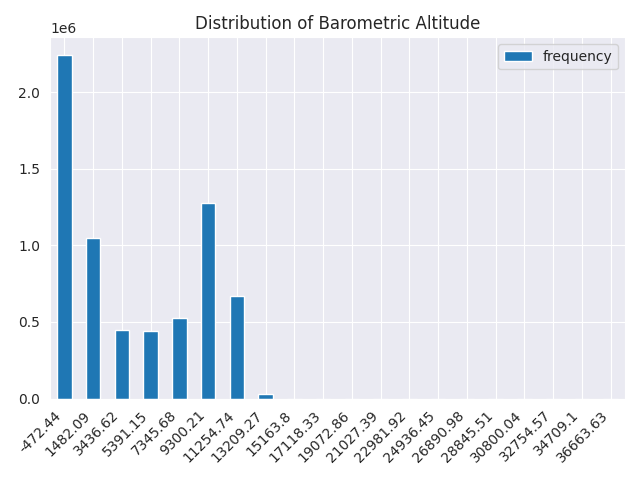

In [ ]:
# Plot the histogram for barometric altitude
plt.figure(figsize=(12, 12))
baroaltitude_hist_df = pd.DataFrame(
    list(zip(*baroaltitude_hist)),
    columns=['bin', 'frequency']
)
baroaltitude_hist_df['bin'] = baroaltitude_hist_df['bin'].round(2)
baroaltitude_hist_df.set_index('bin').plot(kind='bar')
plt.xlabel(None)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Barometric Altitude')
plt.tight_layout()
plt.show()
%matplot plt

**Observation:** We can see that `baroaltitude` is not normally distributed. The distribution is skewed to the right with high-value outliers. For sake of simplicity, we will drop the records where `baroaltitude` is null. 

**NOTE:** Dropping rows with null `baroaltitude` is likely a limitation and should be addressed as a future consideration for improvement.

In [ ]:
# track_points_window = Window.rowsBetween(0, float('inf'))
# track_points_df = track_points_df.withColumn('baroaltitude_imputed', F.last('baroaltitude', ignorenulls=True).over(track_points_window))

In [ ]:
# Save to temporary table and reload to clear cache
# track_points_df.unpersist()
# track_points_df.write.mode('overwrite').saveAsTable('track_points_df')
# track_points_df = spark.read.table('track_points_df')
# track_points_df.persist()

In [ ]:
# Drop null values for baroaltitude
track_points_df = track_points_df.dropna(subset=['baroaltitude'])

In [ ]:
# Get updated missing values report after imputing values
track_points_missing_values_report = get_missing_values(track_points_df)
track_points_missing_values_report.show(n=len(track_points_df.columns), truncate=False)

Execution Interrupted. Attempting to cancel the statement (statement_id=63)


In [ ]:
# Get new record count after dropping null values
track_points_count = track_points_df.count()

In [ ]:
print(f'Track points count after dropping null values: {track_points_count:,}')

Track points count after dropping null values: 1,229,238,805


#### Analyze Uniqueness

In [ ]:
track_points_unique_counts = get_unique_values(track_points_df)
track_points_unique_counts.show(n=len(track_points_df.columns), vertical=True, truncate=False)

-RECORD 0-----------------
 time           | 3666057 
 icao24         | 19491   
 lat            | 962826  
 lon            | 3409735 
 velocity       | 74021   
 heading        | 489644  
 vertrate       | 513     
 callsign       | 27281   
 onground       | 2       
 alert          | 2       
 spi            | 2       
 baroaltitude   | 2309    
 geoaltitude    | 4357    
 lastposupdate  | 5849680 
 lastcontact    | 5943035 
 serials        | 927566  
 day_of_week    | 7       
 daynum_of_week | 7       
 month_name     | 2


In [ ]:
track_points_df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- icao24: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- velocity: double (nullable = true)
 |-- heading: double (nullable = true)
 |-- vertrate: double (nullable = true)
 |-- callsign: string (nullable = true)
 |-- onground: integer (nullable = true)
 |-- alert: integer (nullable = true)
 |-- spi: integer (nullable = true)
 |-- baroaltitude: double (nullable = true)
 |-- geoaltitude: double (nullable = true)
 |-- lastposupdate: double (nullable = true)
 |-- lastcontact: double (nullable = true)
 |-- serials: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- day_of_week: string (nullable = true)
 |-- daynum_of_week: integer (nullable = true)
 |-- month_name: string (nullable = true)


**Observation:** Only a few features are categorical for track points.

Low variance columns (categorical):
* onground
* alert
* spi
* day_of_week
* month_name

Of these features, only `day_of_week` and `month_name` are strings which we created.

#### Analyze Events by Altitude Bins

In [ ]:
alt_bins = [0, 150, 200, 250, 500, 750, 1000, 2500, 5000, 10000, float("inf")]
alt_labels = ['<150', '150-200', '200-250', '250-500', '500-750', '750-1000', '1000-2500', '2500-5000', '5000-10000', '>10000']

In [ ]:
# Create the altitude bins for baroaltitude
track_points_df = track_points_df.withColumn("altitude_bin", 
                   F.when(F.col("baroaltitude") < alt_bins[1], alt_labels[0])
                   .when((F.col("baroaltitude") >= alt_bins[1]) & (F.col("baroaltitude") < alt_bins[2]), alt_labels[1])
                   .when((F.col("baroaltitude") >= alt_bins[2]) & (F.col("baroaltitude") < alt_bins[3]), alt_labels[2])
                   .when((F.col("baroaltitude") >= alt_bins[3]) & (F.col("baroaltitude") < alt_bins[4]), alt_labels[3])
                   .when((F.col("baroaltitude") >= alt_bins[4]) & (F.col("baroaltitude") < alt_bins[5]), alt_labels[4])
                   .when((F.col("baroaltitude") >= alt_bins[5]) & (F.col("baroaltitude") < alt_bins[6]), alt_labels[5])
                   .when((F.col("baroaltitude") >= alt_bins[6]) & (F.col("baroaltitude") < alt_bins[7]), alt_labels[6])
                   .when((F.col("baroaltitude") >= alt_bins[7]) & (F.col("baroaltitude") < alt_bins[8]), alt_labels[7])
                   .when((F.col("baroaltitude") >= alt_bins[8]) & (F.col("baroaltitude") < alt_bins[9]), alt_labels[8])
                   .otherwise(alt_labels[9]))

In [ ]:
# Analyze event score by altitude_bin
print('='*100)
print(f'OpenSky Network Track Points by Altitude Bin')
print('='*100)
track_points_df.groupBy('altitude_bin').agg(
    F.count('*').alias('track_points_count'),
).orderBy(F.col('track_points_count').desc()).show()

OpenSky Network Track Points by Altitude Bin
+------------+------------------+
|altitude_bin|track_points_count|
+------------+------------------+
|      >10000|          16764454|
|  5000-10000|           9392830|
|   1000-2500|           7934471|
|   2500-5000|           4718559|
|     250-500|           3160821|
|     500-750|           2873693|
|    750-1000|           2631313|
|        <150|           1395922|
|     200-250|            579841|
|     150-200|            546516|
+------------+------------------+


#### Filter by Altitude to Match Grids Ceiling
Filtering by altitude to match the min/max range of UASFM grid ceilings will ensure only the records of interest get analyzed for geospatial risk analysis.

In [62]:
track_points_df = track_points_df.filter(track_points_df["baroaltitude"].between(min_ceiling, max_ceiling))

In [63]:
filtered_track_points_count = track_points_df.count()

In [64]:
print(f'Filtered track points count: {filtered_track_points_count:,}')

Filtered track points count: 27,362,475


#### Save Filtered Track Points by Grid Ceiling

In [ ]:
# track_points_df = track_points_df.withColumn('year', F.year('time'))\
#                                  .withColumn('month', F.month('time'))\
#                                  .withColumn('day', F.dayofmonth('time'))\
#                                  .withColumn('hour', F.hour('time'))

In [ ]:
# Write the DataFrame to Parquet format, partitioned by year, month, day, and hour
# track_points_df.write.partitionBy("year", "month", "day", "hour")\
#                       .parquet("s3://endurasoft-dev-risk-framework/datasets/grid-ceiling-track-points/")

#### Load Filtered Track Points by Grid Ceiling

In [ ]:
# track_points_df = spark.read.parquet("s3://endurasoft-dev-risk-framework/datasets/grid-ceiling-track-points/year=*/month=*/day=*/hour=*/*.parquet")

#### Add Point Geometry for Track Points

In [65]:
# Create schema for RDD
track_points_schema = T.StructType(list(track_points_df.schema) + [T.StructField("point_wkt", T.StringType(), True)])

# Capture RDD
track_points_rdd = track_points_df.rdd

# Add point geometry
track_points_rdd = track_points_rdd.map(lambda row: add_point_wkt(row, lat_col='lat', lon_col='lon', alt_col='baroaltitude', point_wkt_col='point_wkt'))

# Transform RDD with point geometry back to spark dataframe
track_points_df = spark.createDataFrame(track_points_rdd, schema=track_points_schema).persist()

In [66]:
# Convert point WKT to geometry using sedona
track_points_df = track_points_df.withColumn("point_geometry", F.expr("ST_GeomFromWKT(point_wkt)"))

In [67]:
track_points_df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- icao24: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- velocity: double (nullable = true)
 |-- heading: double (nullable = true)
 |-- vertrate: double (nullable = true)
 |-- callsign: string (nullable = true)
 |-- onground: integer (nullable = true)
 |-- alert: integer (nullable = true)
 |-- spi: integer (nullable = true)
 |-- baroaltitude: double (nullable = true)
 |-- geoaltitude: double (nullable = true)
 |-- lastposupdate: double (nullable = true)
 |-- lastcontact: double (nullable = true)
 |-- serials: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- day_of_week: string (nullable = true)
 |-- daynum_of_week: integer (nullable = true)
 |-- month_name: string (nullable = true)
 |-- point_wkt: string (nullable = true)
 |-- point_geometry: geometry (nullable = false)


In [68]:
track_points_df.show(n=1, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------
 time           | 2024-07-19 11:00:02                                   
 icao24         | a025bc                                                
 lat            | 29.309646606445312                                    
 lon            | -81.1421673114483                                     
 velocity       | 53.800611565858915                                    
 heading        | 6.037682521422889                                     
 vertrate       | 4.22656                                               
 callsign       | JED122                                                
 onground       | 0                                                     
 alert          | 0                                                     
 spi            | 0                                                     
 baroaltitude   | 281.94                                                
 geoaltitude    | 289.56                           

**Observation:** Unfortunately, Apache Sedona does not support 3D point geometry and has automatically converted the 3D point WKT to a 2D point geomtry. Therefore, we will need to consider altitude as a separate clause during geospatial joins.

## Data Fusion
Use geospatial analysis to identify which UASFM grids the track points and uas sightings overlap and assign a unique grid ID accordingly to each record. The goal it to end up with a single cohesive dataset representing a join between track points, uas sightings, and UASFM grids, where each record has a UASFM global id associated with it.

In [69]:
# Create small sample of track points for testing geospatial join
target_n = 200_000
frac = target_n / track_points_count
sample_track_points_df = track_points_df.sample(frac, seed=42)
sample_track_points_df.persist()

DataFrame[time: timestamp, icao24: string, lat: double, lon: double, velocity: double, heading: double, vertrate: double, callsign: string, onground: int, alert: int, spi: int, baroaltitude: double, geoaltitude: double, lastposupdate: double, lastcontact: double, serials: array<bigint>, day_of_week: string, daynum_of_week: int, month_name: string, point_wkt: string, point_geometry: udt]


In [70]:
# Set target track points dataframe for remainder of analysis
target_track_points_df = sample_track_points_df
# target_track_points_df = track_points_df

In [71]:
# Calculate total flight operations based on count of unique flight ids
total_ops = target_track_points_df.select('icao24').distinct().count()

In [72]:
print(f'Total flight operations: {total_ops:,}')

Total flight operations: 17,952


In [73]:
# Build the spatial index on track points
target_track_points_rdd = Adapter.toSpatialRdd(target_track_points_df, "point_geometry")
target_track_points_rdd.analyze()
target_track_points_rdd.spatialPartitioning(GridType.KDBTREE)
target_track_points_rdd.buildIndex(IndexType.RTREE, True)
target_track_points_df = Adapter.toDf(target_track_points_rdd, spark)
target_track_points_df.persist()

DataFrame[geometry: udt, time: string, icao24: string, lat: string, lon: string, velocity: string, heading: string, vertrate: string, callsign: string, onground: string, alert: string, spi: string, baroaltitude: string, geoaltitude: string, lastposupdate: string, lastcontact: string, serials: string, day_of_week: string, daynum_of_week: string, month_name: string, point_wkt: string]


In [74]:
# Build the spatial index on UASFM grids
uasfm_rdd = Adapter.toSpatialRdd(uasfm_df, "geometry")
uasfm_rdd.analyze()
uasfm_rdd.spatialPartitioning(GridType.KDBTREE)
uasfm_rdd.buildIndex(IndexType.RTREE, True)
uasfm_df = Adapter.toDf(uasfm_rdd, spark)
uasfm_df.persist()

DataFrame[geometry: udt, objectid: string, ceiling: string, unit: string, map_eff: string, last_edit: string, latitude: string, longitude: string, globalid: string, arpt_count: string, apt1_faaid: string, apt1_icao: string, apt1_name: string, apt1_laanc: string, apt2_faaid: string, apt2_icao: string, apt2_name: string, apt2_laanc: string, apt3_faaid: string, apt3_icao: string, apt3_name: string, apt3_laanc: string, apt4_faaid: string, apt4_icao: string, apt4_name: string, apt4_laanc: string, apt5_faaid: string, apt5_icao: string, apt5_name: string, apt5_laanc: string, airs_count: string, airspace_1: string, airspace_2: string, airspace_3: string, airspace_4: string, airspace_5: string, region: string, apt1_enabled: string, apt2_enabled: string, apt3_enabled: string, apt4_enabled: string, apt5_enabled: string, shape__length: string, shape__area: string, shape__area_2: string, shape__length_2: string, wkt: string]


In [75]:
# Build the spatial index on uas sightings
uas_sightings_rdd = Adapter.toSpatialRdd(uas_sightings_df, "point_geometry")
uas_sightings_rdd.analyze()
uas_sightings_rdd.spatialPartitioning(GridType.KDBTREE)
uas_sightings_rdd.buildIndex(IndexType.RTREE, True)
uas_sightings_df = Adapter.toDf(uas_sightings_rdd, spark)
uas_sightings_df.persist()

DataFrame[geometry: udt, id: string, report_date: string, city: string, state: string, report_narrative: string, timestamp: string, latitude: string, longitude: string, altitude: string, uncertainty: string, point_wkt: string]


In [76]:
# Register UASFM grids, flight tracks, and UAS sightings as temporary views
uasfm_df.createOrReplaceTempView("uasfm_grids")
target_track_points_df.createOrReplaceTempView("track_points")
uas_sightings_df.createOrReplaceTempView("uas_sightings")

#### Run Geospatial Risk Query

In [77]:
# Get all columns from the uasfm DataFrame
grid_columns = uasfm_df.columns

# Format columns for the SELECT and GROUP BY clauses
select_columns = ", ".join([f"g.{col}" for col in grid_columns])
group_by_columns = ", ".join([f"g.{col}" for col in grid_columns])

In [78]:
# Verify there are no track points outside of the grid ceiling range
spark.sql(f'SELECT COUNT(*) AS COUNT FROM track_points f WHERE f.baroaltitude BETWEEN {min_ceiling} AND {max_ceiling}').show(truncate=False)

+------+
|COUNT |
+------+
|200483|
+------+


In [87]:
target_track_points_count = target_track_points_df.count()
print(f'Target track points count: {target_track_points_count:,}')

Target track points count: 200,483


##### Track Points Intersections

In [82]:
track_points_intersections_query = """
SELECT f.*, g.globalid
FROM track_points f
LEFT JOIN uasfm_grids g ON ST_Intersects(g.geometry, f.geometry)
"""

track_points_intersections_df = spark.sql(track_points_intersections_query)

In [83]:
track_points_intersections_df.persist()

DataFrame[geometry: udt, time: string, icao24: string, lat: string, lon: string, velocity: string, heading: string, vertrate: string, callsign: string, onground: string, alert: string, spi: string, baroaltitude: string, geoaltitude: string, lastposupdate: string, lastcontact: string, serials: string, day_of_week: string, daynum_of_week: string, month_name: string, point_wkt: string, globalid: string]


In [88]:
track_points_intersections_df.show(n=1, vertical=True)

-RECORD 0------------------------------
 geometry       | POINT (-81.104982... 
 time           | 2024-07-19 11:04:... 
 icao24         | a025bc               
 lat            | 29.303421020507812   
 lon            | -81.10498281625598   
 velocity       | 36.12114978292468    
 heading        | 259.33021719550334   
 vertrate       | -2.27584             
 callsign       | JED122               
 onground       | 0                    
 alert          | 0                    
 spi            | 0                    
 baroaltitude   | 0.0                  
 geoaltitude    | 7.62                 
 lastposupdate  | 1.721387015906E9     
 lastcontact    | 1.721387015906E9     
 serials        | WrappedArray()       
 day_of_week    | Friday               
 daynum_of_week | 6                    
 month_name     | July                 
 point_wkt      | POINT Z (-81.1049... 
 globalid       | 419a3255-25ec-4e3... 
only showing top 1 row


In [ ]:
# Get count of intersections
track_point_intersections_count = track_points_intersections_df.filter(F.col("globalid").isNotNull()).count()

In [93]:
# Analyze difference
print(f'{track_point_intersections_count:,} of {target_track_points_count:,} track points intersected with grids ({(track_point_intersections_count/target_track_points_count)*100:.2f}%)')

130,004 of 200,483 track points intersected with grids (64.85%)


##### UAS Sightings Intersections

In [94]:
uas_sightings_intersections_query = """
SELECT u.*, g.globalid
FROM uas_sightings u
LEFT JOIN uasfm_grids g ON ST_Intersects(g.geometry, u.geometry)
"""

uas_sightings_intersections_df = spark.sql(uas_sightings_intersections_query)

In [98]:
uas_sightings_intersections_df.persist()

DataFrame[geometry: udt, id: string, report_date: string, city: string, state: string, report_narrative: string, timestamp: string, latitude: string, longitude: string, altitude: string, uncertainty: string, point_wkt: string, globalid: string]


In [95]:
uas_sightings_intersections_df.show(n=1, vertical=True)

-RECORD 0--------------------------------
 geometry         | POINT (-155.9956 ... 
 id               | 7818                 
 report_date      | 2024-07-06           
 city             | Kailua-kona          
 state            | Hawaii               
 report_narrative | Prelim informatio... 
 timestamp        | 2024-07-06T00:00:00Z 
 latitude         | 19.6392              
 longitude        | -155.9956            
 altitude         | 0                    
 uncertainty      | medium               
 point_wkt        | POINT Z (-155.995... 
 globalid         | null                 
only showing top 1 row


In [96]:
uas_sightings_intersections_count = uas_sightings_intersections_df.filter(F.col("globalid").isNotNull()).count()

In [97]:
# Analyze difference
print(f'{uas_sightings_intersections_count:,} of {filtered_uas_sightings_count:,} UAS sightings intersected with grids ({(uas_sightings_intersections_count/filtered_uas_sightings_count)*100:.2f}%)')

11 of 111 UAS sightings intersected with grids (9.91%)


##### Join with Grids

In [99]:
# Create views for track points and uas sightings intersections
track_points_intersections_df.createOrReplaceTempView('track_points_intersections')
uas_sightings_intersections_df.createOrReplaceTempView('uas_sightings_intersections')

In [105]:
# Join intersection results to create intersection counts columns for track points and uas sightings in the uasfm grids dataset
# NOTE: Assuming altitudes are in sync with min/max range for ceilings between track points and uas sightings
joined_grids_query = f"""
WITH grids_join AS (
    SELECT g.globalid, 
           COUNT(tx.icao24) AS flight_int_count, 
           COUNT(ux.id) AS uas_sighting_int_count
    FROM uasfm_grids g
    LEFT JOIN track_points_intersections tx ON g.globalid = tx.globalid
    LEFT JOIN uas_sightings_intersections ux on g.globalid = ux.globalid
    GROUP BY g.globalid
)
SELECT globalid, flight_int_count, uas_sighting_int_count, SUM((flight_int_count + uas_sighting_int_count) / {total_ops}) AS risk_factor
FROM grids_join
GROUP BY globalid, flight_int_count, uas_sighting_int_count
"""

joined_grids_df = spark.sql(joined_grids_query)

In [106]:
joined_grids_df.persist()

DataFrame[globalid: string, flight_int_count: bigint, uas_sighting_int_count: bigint, risk_factor: double]


In [107]:
joined_grids_df.show(n=1, vertical=True)

-RECORD 0--------------------------------------
 globalid               | 00017c46-d5bc-4c7... 
 flight_int_count       | 0                    
 uas_sighting_int_count | 0                    
 risk_factor            | 0.0                  
only showing top 1 row


In [108]:
joined_grids_count = joined_grids_df.count()

In [109]:
# Verify correct number of records (should match original count of grids)
print(f'Total grids        : {uasfm_grids_count:,}')
print(f'Total joined grids : {joined_grids_count:,}')

Total grids        : 376,569
Total joined grids : 376,569


In [110]:
joined_grids_df.select('flight_int_count', 'uas_sighting_int_count', 'risk_factor').describe().show(truncate=False)

+-------+-------------------+----------------------+---------------------+
|summary|flight_int_count   |uas_sighting_int_count|risk_factor          |
+-------+-------------------+----------------------+---------------------+
|count  |376569             |376569                |376569               |
|mean   |0.34523287896773236|8.232223045444527E-5  |1.9235472437509965E-5|
|stddev |4.488134155697167  |0.03311707549928575   |2.5002727406767355E-4|
|min    |0                  |0                     |0.0                  |
|max    |533                |20                    |0.029690285204991087 |
+-------+-------------------+----------------------+---------------------+


##### Compute Risk Scores (Normalization)

In [115]:
# Create vector assembler
assembler = VectorAssembler(inputCols=["risk_factor"], outputCol="risk_factor_vect")
joined_grids_df = assembler.transform(joined_grids_df)

In [120]:
# Apply min/max scaling to risk factor
min_max_scaler = MinMaxScaler(inputCol="risk_factor_vect", outputCol="risk_score")
min_max_model = min_max_scaler.fit(joined_grids_df)
risk_scores_df = min_max_model.transform(joined_grids_df)\
                              .drop('risk_factor_vect')

In [121]:
risk_scores_df.persist()

DataFrame[globalid: string, flight_int_count: bigint, uas_sighting_int_count: bigint, risk_factor: double, risk_score: vector]


In [122]:
# Convert risk score from dense vector to double
unlist = F.udf(lambda x: float(list(x)[0]), T.DoubleType())
risk_scores_df = risk_scores_df.withColumn('risk_score', unlist('risk_score'))

In [123]:
risk_scores_df.show(n=1, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------
 globalid               | 00017c46-d5bc-4c72-b379-127c8c63de2d 
 flight_int_count       | 0                                    
 uas_sighting_int_count | 0                                    
 risk_factor            | 0.0                                  
 risk_score             | 0.0                                  
only showing top 1 row


In [124]:
# Verify values for risk score are between 0 and 1
risk_scores_df.select('risk_score').describe().show(truncate=False)

+-------+--------------------+
|summary|risk_score          |
+-------+--------------------+
|count  |376569              |
|mean   |6.478709215725743E-4|
|stddev |0.00842118128342004 |
|min    |0.0                 |
|max    |0.9999999999999999  |
+-------+--------------------+


In [129]:
# Create rule-based risk label column
risk_scores_df = risk_scores_df.withColumn('risk_label', F.when(F.col('risk_score') >= 0.2, 'HIGH')\
                                                          .when((F.col('risk_score') >= 0.1) & (F.col('risk_score') < 0.2), 'MEDIUM')\
                                                          .otherwise('LOW')
                                          )

In [130]:
# Analyze risk labels
risk_scores_df.groupBy('risk_label').count().show(truncate=False)

+----------+------+
|risk_label|count |
+----------+------+
|LOW       |376227|
|MEDIUM    |218   |
|HIGH      |124   |
+----------+------+


In [131]:
# Join back with original grids to obtain grid columns
risk_scores_df = uasfm_df.join(risk_scores_df, on='globalid', how='left')

In [ ]:
# SQL query to calculate intersections and risk scores
# risk_scores_query = f"""
# SELECT 
#     {select_columns},
#     SUM(CASE WHEN f.geometry IS NOT NULL AND f.baroaltitude <= g.ceiling THEN 1 ELSE 0 END) AS flight_intersections,
#     SUM(CASE WHEN u.geometry IS NOT NULL AND u.altitude <= g.ceiling THEN 1 ELSE 0 END) AS uas_sightings_intersections,
#     COALESCE(
#         (SUM(CASE WHEN f.geometry IS NOT NULL AND f.baroaltitude <= g.ceiling THEN 1 ELSE 0 END) +
#          SUM(CASE WHEN u.geometry IS NOT NULL AND u.altitude <= g.ceiling THEN 1 ELSE 0 END)) / NULLIF(g.ceiling, 0),
#         0
#     ) AS risk_score
# FROM 
#     uasfm_grids g
# LEFT JOIN 
#     uas_sightings u ON ST_Intersects(g.geometry, u.geometry)
# LEFT JOIN 
#     track_points f ON ST_Intersects(g.geometry, f.geometry)
# GROUP BY 
#     {group_by_columns}
# """

# # Execute the query and load results into a DataFrame
# risk_scores_df = spark.sql(risk_scores_query)

In [132]:
risk_scores_df.persist()

DataFrame[globalid: string, geometry: udt, objectid: string, ceiling: string, unit: string, map_eff: string, last_edit: string, latitude: string, longitude: string, arpt_count: string, apt1_faaid: string, apt1_icao: string, apt1_name: string, apt1_laanc: string, apt2_faaid: string, apt2_icao: string, apt2_name: string, apt2_laanc: string, apt3_faaid: string, apt3_icao: string, apt3_name: string, apt3_laanc: string, apt4_faaid: string, apt4_icao: string, apt4_name: string, apt4_laanc: string, apt5_faaid: string, apt5_icao: string, apt5_name: string, apt5_laanc: string, airs_count: string, airspace_1: string, airspace_2: string, airspace_3: string, airspace_4: string, airspace_5: string, region: string, apt1_enabled: string, apt2_enabled: string, apt3_enabled: string, apt4_enabled: string, apt5_enabled: string, shape__length: string, shape__area: string, shape__area_2: string, shape__length_2: string, wkt: string, flight_int_count: bigint, uas_sighting_int_count: bigint, risk_factor: dou

In [133]:
# NOTE: Runtime took 2h 11m 54s with 2 G.2X workers running glue 3.0 on 100k track points
risk_scores_df.show(n=1, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 globalid               | 00017c46-d5bc-4c72-b379-127c8c63de2d                                                                                                                                                                       
 geometry               | POLYGON ((-159.808333318407 21.9750038051595, -159.808333318407 21.9833371404548, -159.799999983112 21.9833371404548, -159.799999983112 21.9750038051595, -159.808333318407 21.9750038051595))             
 objectid               | 260889                                                                                                                                                                                                     
 ceiling                | 0                                                     

#### Save Risk Scores

In [134]:
risk_scores_outpath = 's3://endurasoft-dev-risk-framework/analysis/uas_risk_scores/v3/'
risk_scores_csv_path = os.path.join(risk_scores_outpath, 'consolidated/uas_risk_scores_csv/')
risk_scores_viz_path = os.path.join(risk_scores_outpath, 'viz/')

In [135]:
# risk_scores_df.write.format("csv").save("/path/to/output/risk_scores.csv")
risk_scores_df.coalesce(1).write.parquet(path=risk_scores_outpath, mode='overwrite')

In [136]:
# Convert risk scores dataframe to pandas
risk_scores_pd_df = risk_scores_df.drop('geometry').toPandas()

In [137]:
# Save csv version for downstream analysis
# risk_scores_df.drop('geometry').coalesce(1).write.csv(path=risk_scores_csv_path, header='true', mode='overwrite')
risk_scores_pd_df.to_csv(os.path.join(risk_scores_csv_path, 'uas_risk_scores.csv'), index=False)

In [138]:
# Convert risk scores dataframe to geopandas
risk_scores_gdf = gpd.GeoDataFrame(
    risk_scores_pd_df,
    geometry=gpd.GeoSeries.from_wkt(risk_scores_pd_df['wkt'])
)

In [ ]:
# Save shapefile for dowstream visualization
# NOTE: Cannot do this in glue pyspark kernel. It will work but there is no way to obtain the files locally
# risk_scores_gdf.to_file('uas_risk_scores.shp', driver='ESRI Shapefile')

In [139]:
# Save geojson for downstream visualization
risk_scores_gdf.to_file(os.path.join(risk_scores_viz_path, 'uas_risk_scores.geojson'), driver='GeoJSON')

#### Load Risk Scores

In [140]:
risk_scores_df = spark.read.parquet(os.path.join(risk_scores_outpath, '*.parquet'))
risk_scores_df.persist()

DataFrame[globalid: string, geometry: udt, objectid: string, ceiling: string, unit: string, map_eff: string, last_edit: string, latitude: string, longitude: string, arpt_count: string, apt1_faaid: string, apt1_icao: string, apt1_name: string, apt1_laanc: string, apt2_faaid: string, apt2_icao: string, apt2_name: string, apt2_laanc: string, apt3_faaid: string, apt3_icao: string, apt3_name: string, apt3_laanc: string, apt4_faaid: string, apt4_icao: string, apt4_name: string, apt4_laanc: string, apt5_faaid: string, apt5_icao: string, apt5_name: string, apt5_laanc: string, airs_count: string, airspace_1: string, airspace_2: string, airspace_3: string, airspace_4: string, airspace_5: string, region: string, apt1_enabled: string, apt2_enabled: string, apt3_enabled: string, apt4_enabled: string, apt5_enabled: string, shape__length: string, shape__area: string, shape__area_2: string, shape__length_2: string, wkt: string, flight_int_count: bigint, uas_sighting_int_count: bigint, risk_factor: dou

In [141]:
risk_scores_count = risk_scores_df.count()

In [142]:
print(f'Total risk score records: {risk_scores_count:,}')

Total risk score records: 376,569


**Observation:** Total number of records in risk analysis dataframe matches total number of UASFM grids which is the desired result.

#### Analyze Risk Scores

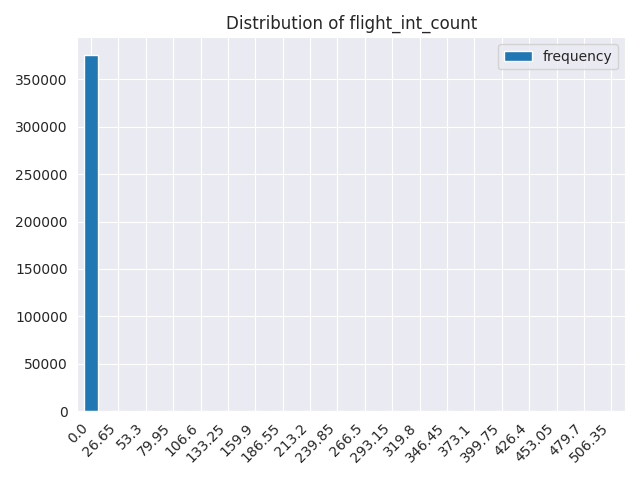

In [144]:
# Analyze distribution of flight intersections with grids
generate_histplot(risk_scores_df, feature_col='flight_int_count')
%matplot plt

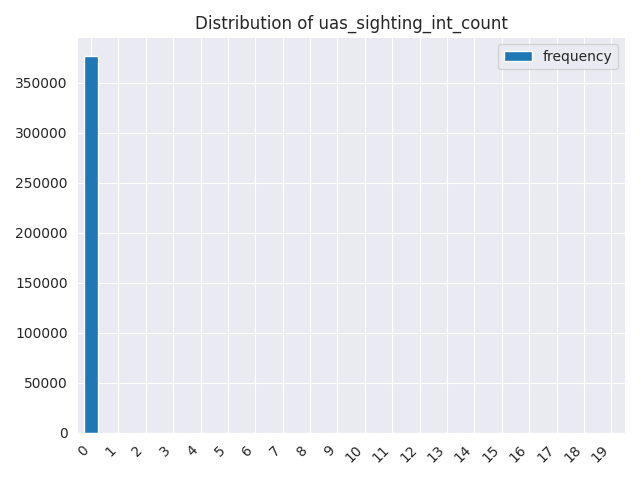

In [145]:
# Analyze distribution of UAS sightings intersections with grids
generate_histplot(risk_scores_df, feature_col='uas_sighting_int_count')
%matplot plt

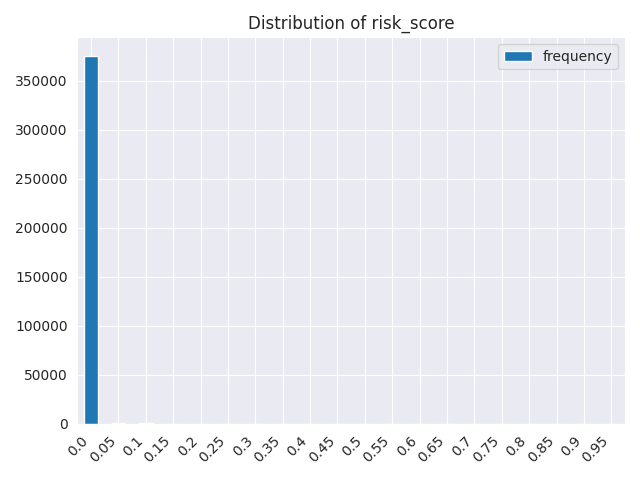

In [146]:
# Analyze distribution of risk score
generate_histplot(risk_scores_df, feature_col='risk_score')
%matplot plt

In [147]:
# Describe results
risk_scores_df.select('flight_int_count', 'uas_sighting_int_count', 'risk_score').describe().show(truncate=False)

+-------+-------------------+----------------------+--------------------+
|summary|flight_int_count   |uas_sighting_int_count|risk_score          |
+-------+-------------------+----------------------+--------------------+
|count  |376569             |376569                |376569              |
|mean   |0.34523287896773236|8.232223045444527E-5  |6.478709215727341E-4|
|stddev |4.488134155697113  |0.033117075499286136  |0.00842118128342009 |
|min    |0                  |0                     |0.0                 |
|max    |533                |20                    |0.9999999999999999  |
+-------+-------------------+----------------------+--------------------+


### (Future Capability) Build Visualization Files
Goal is to create a heatmap for track points and points for UAS sightings as overlay layers in map visualization.

### Aggregate Analysis
Analyze fused dataset for near mid-air collision (NMAC) and mid-air collision (MAC) risk for UAS.

In [149]:
combined_df = target_track_points_df

In [150]:
combined_df = combined_df.withColumn('lat', F.col('lat').cast('double'))\
                         .withColumn('lon', F.col('lon').cast('double'))

#### Analyze by Geolocation

##### Clustered Heatmap (Folium)

In [151]:
cell_size = 0.007

df_grid = combined_df.withColumn("grid_lat", F.floor(combined_df["lat"] / cell_size) * cell_size) \
             .withColumn("grid_lon", F.floor(combined_df["lon"] / cell_size) * cell_size) \
             .groupBy("grid_lat", "grid_lon") \
             .agg(F.count("*").alias("point_count"))

In [152]:
df_grid_pandas = df_grid.toPandas()

In [153]:
df_grid_pandas

       grid_lat  grid_lon  point_count
0        29.309   -81.144            9
1        29.288   -81.221            1
2        36.106   -86.695           18
3        29.946   -81.312            4
4        43.162   -77.658            1
...         ...       ...          ...
55156    29.876   -95.501            1
55157    27.727   -97.601            1
55158    46.389   -94.129            2
55159    44.212   -93.919            1
55160    39.823   -82.950            1

[55161 rows x 3 columns]


In [154]:
map_center = [df_grid_pandas["grid_lat"].mean(), df_grid_pandas["grid_lon"].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# Create the heatmap layer
heatmap_layer = HeatMap(
    data=df_grid_pandas[["grid_lat", "grid_lon", "point_count"]].values.tolist(),
    radius=15, 
    blur=10
)
heatmap_layer.add_to(m)
m

In [155]:
# Save as html
map_filename = 'uas_risk_analysis_geolocation.html'
buf = io.BytesIO(m._repr_html_().encode('utf-8'))
s3_client.put_object(Bucket='endurasoft-dev-risk-framework', Key=f'analysis/eda_results/{map_filename}', Body=buf)
buf.close()

##### Shader-based Point Density Heatmap (Plotly)

In [156]:
combined_df = combined_df.withColumn('time', F.to_timestamp('time'))

In [157]:
# Determine average time diff in seconds between events; this will help determine reduction ratio
# Calculate the time difference between consecutive records
window = Window.orderBy(F.col("time"))
combined_df = combined_df.withColumn("prev_timestamp", F.lag("time").over(window))
combined_df = combined_df.withColumn("time_diff", F.unix_timestamp("time") - F.unix_timestamp("prev_timestamp"))

# Calculate the average time difference in seconds
avg_time_diff = combined_df.agg(F.avg("time_diff")).collect()[0][0]

print("Average time difference in seconds:", avg_time_diff)

Average time difference in seconds: 39.216129128799594


In [158]:
# Create year, month, day, hour, minute, seconds columns
combined_df = combined_df.withColumn("year", F.year("time")) \
                         .withColumn("month", F.month("time")) \
                         .withColumn("day", F.dayofmonth("time")) \
                         .withColumn("hour", F.hour("time")) \
                         .withColumn("minute", F.minute("time")) \
                         .withColumn("second", F.second("time"))

In [159]:
# Apply date range based windowing based on https://stackoverflow.com/a/45824339
# NOTE: This will take a while to run depending on the size of the dataset
# Function to calculate number of seconds from number of days
days_to_seconds = lambda i: i * 86400

# Create window by casting timestamp to long (number of seconds)
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Window.rangeBetween.html
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Window.rowsBetween.html
window_spec = Window.partitionBy("icao24").orderBy(F.col("time").cast('long')).rangeBetween(-days_to_seconds(1), 0)

# Calculate the moving average for latitude and longitude
windowed_df = combined_df.withColumn("avg_latitude", F.avg("lat").over(window_spec))
windowed_df = windowed_df.withColumn("avg_longitude", F.avg("lon").over(window_spec))

# Drop duplicates to further reduce density
mav_df = windowed_df.dropDuplicates(["icao24", "avg_latitude", "avg_longitude"])

In [160]:
# Analyze density reduction with moving average
f'{combined_df.count():,}', f'{mav_df.count():,}'

('200,483', '184,176')


In [161]:
reduced_df = combined_df.withColumn('trunc_timestamp', F.date_trunc('second', F.col('time')))\
                        .groupBy('trunc_timestamp')\
                        .agg(*[F.first(col).alias(col) for col in combined_df.columns])\
                        .select(*combined_df.columns)\
                        .orderBy(F.col('time').asc())

In [162]:
# Analyze density reduction with date truncation
f'{combined_df.count():,}', f'{reduced_df.count():,}'

('200,483', '197,573')


In [ ]:
# sampled_df = combined_df.sample(fraction=0.1, seed=42)

In [ ]:
# Analyze density reduction with sampling
# f'{combined_df.count():,}', f'{sampled_df.count():,}'

In [163]:
sampled_df_pandas = reduced_df.drop('geometry').toPandas()

In [164]:
sampled_df_pandas[['lat', 'lon']].sample(10)

              lat         lon
83782   42.192902  -83.390850
85880   48.512972 -123.045068
170652  38.670410  -90.638700
55684   28.549929  -81.321232
47404   48.048248 -122.831612
177560  33.797882 -118.330377
113819  32.728411 -117.168629
141461  28.823190  -81.841467
93939   41.428233  -81.828727
127428  41.406679  -70.596548


In [165]:
# Plot Latitude & Longitude on a map using plotly and datashader - https://plotly.com/python/datashader/
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(sampled_df_pandas, x='lon', y='lat')
coords_lat, coords_lon = agg.coords['lat'].values, agg.coords['lon'].values

# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

img = tf.shade(agg, cmap=fire)[::-1].to_pil()

# Trick to create rapidly a figure with mapbox axes
fig = px.scatter_mapbox(
    sampled_df_pandas[:1], # First row, all columns
    lat='lat', 
    lon='lon',
    opacity=0.0, # Hidden
    zoom=10,
    height=600,
    width=1600,
    center={'lat': 36.778259, 'lon': -119.417931}, # California
)

# Add the datashader image as a mapbox layer image
fig.update_layout(
    mapbox_style="carto-darkmatter",
    mapbox_layers = [
        {
            "sourcetype": "image",
            "source": img,
            "coordinates": coordinates
        }
    ],
    margin=dict(l = 0, r = 0, t = 0, b = 0),
)
fig.show()

In [166]:
# Save the plotly heatmap
string_buf = io.StringIO()
fig.write_html(string_buf)
string_buf.seek(0)

string_data = string_buf.getvalue()
bytes_buf = io.BytesIO(string_data.encode('utf-8'))

fig_filename = 'uas_risk_analysis_plotly_heatmap_shader.html'
s3_client.put_object(Bucket='endurasoft-dev-risk-framework', Key=f'analysis/eda_results/{fig_filename}', Body=bytes_buf)
bytes_buf.close()
string_buf.close()

#### KMeans Clustering by Location

In [167]:
combined_df = combined_df.drop('location_features')

In [168]:
k = 10 
kmeans = KMeans(k=k, featuresCol="location_features")

# Assemble features into a vector
assembler = VectorAssembler(inputCols=["lat", "lon"], outputCol="location_features")
combined_df = assembler.transform(combined_df)

# Train the model
kmeans_model = kmeans.fit(combined_df)

# Assign cluster labels to each track point
combined_df = kmeans_model.transform(combined_df)

In [169]:
combined_df.show(n=1, vertical=True, truncate=True)

-RECORD 0---------------------------------
 geometry          | POINT (-81.252347... 
 time              | 2024-07-01 00:03:29  
 icao24            | a0158c               
 lat               | 28.920639038085938   
 lon               | -81.25234750600961   
 velocity          | 67.86957352239722    
 heading           | 243.43494882292202   
 vertrate          | -2.60096             
 callsign          | N104WH               
 onground          | 0                    
 alert             | 0                    
 spi               | 0                    
 baroaltitude      | 365.76               
 geoaltitude       | 434.34000000000003   
 lastposupdate     | 1.71979220231E9      
 lastcontact       | 1.719792202739E9     
 serials           | WrappedArray(-140... 
 day_of_week       | Monday               
 daynum_of_week    | 2                    
 month_name        | July                 
 point_wkt         | POINT Z (-81.2523... 
 prev_timestamp    | null                 
 time_diff 

In [170]:
combined_df.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         6|24328|
|         9| 4014|
|         5|33697|
|         7|12584|
|         1| 7420|
|         3| 5759|
|         2|34338|
|         4|15600|
|         0|45984|
|         8|16759|
+----------+-----+


**Observation:** We can see that with 10 clusters, there is a fairly even distribution of track points spread across each cluster, with a few clusters, such as cluster 1, 3, and 9 containing far fewer track points than the other clusters. This may indicate that clusters 1, 3, and 9, share unique flight patterns that the other clusters do not.

## Clean up Resources

In [ ]:
# %status

In [16]:
%stop_session

Stopping session: b4961618-1c6e-4d3b-a9bd-e039331319b7
Stopped session.
